In [2]:
import tensorflow as tf
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add, Input, Flatten
from keras import optimizers, initializers, regularizers, metrics
from keras import backend as K

import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

BATCH_SIZE = 256  # Big enough to measure an F1-score
# Adapt preprocessing and prefetching dynamically
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 8192


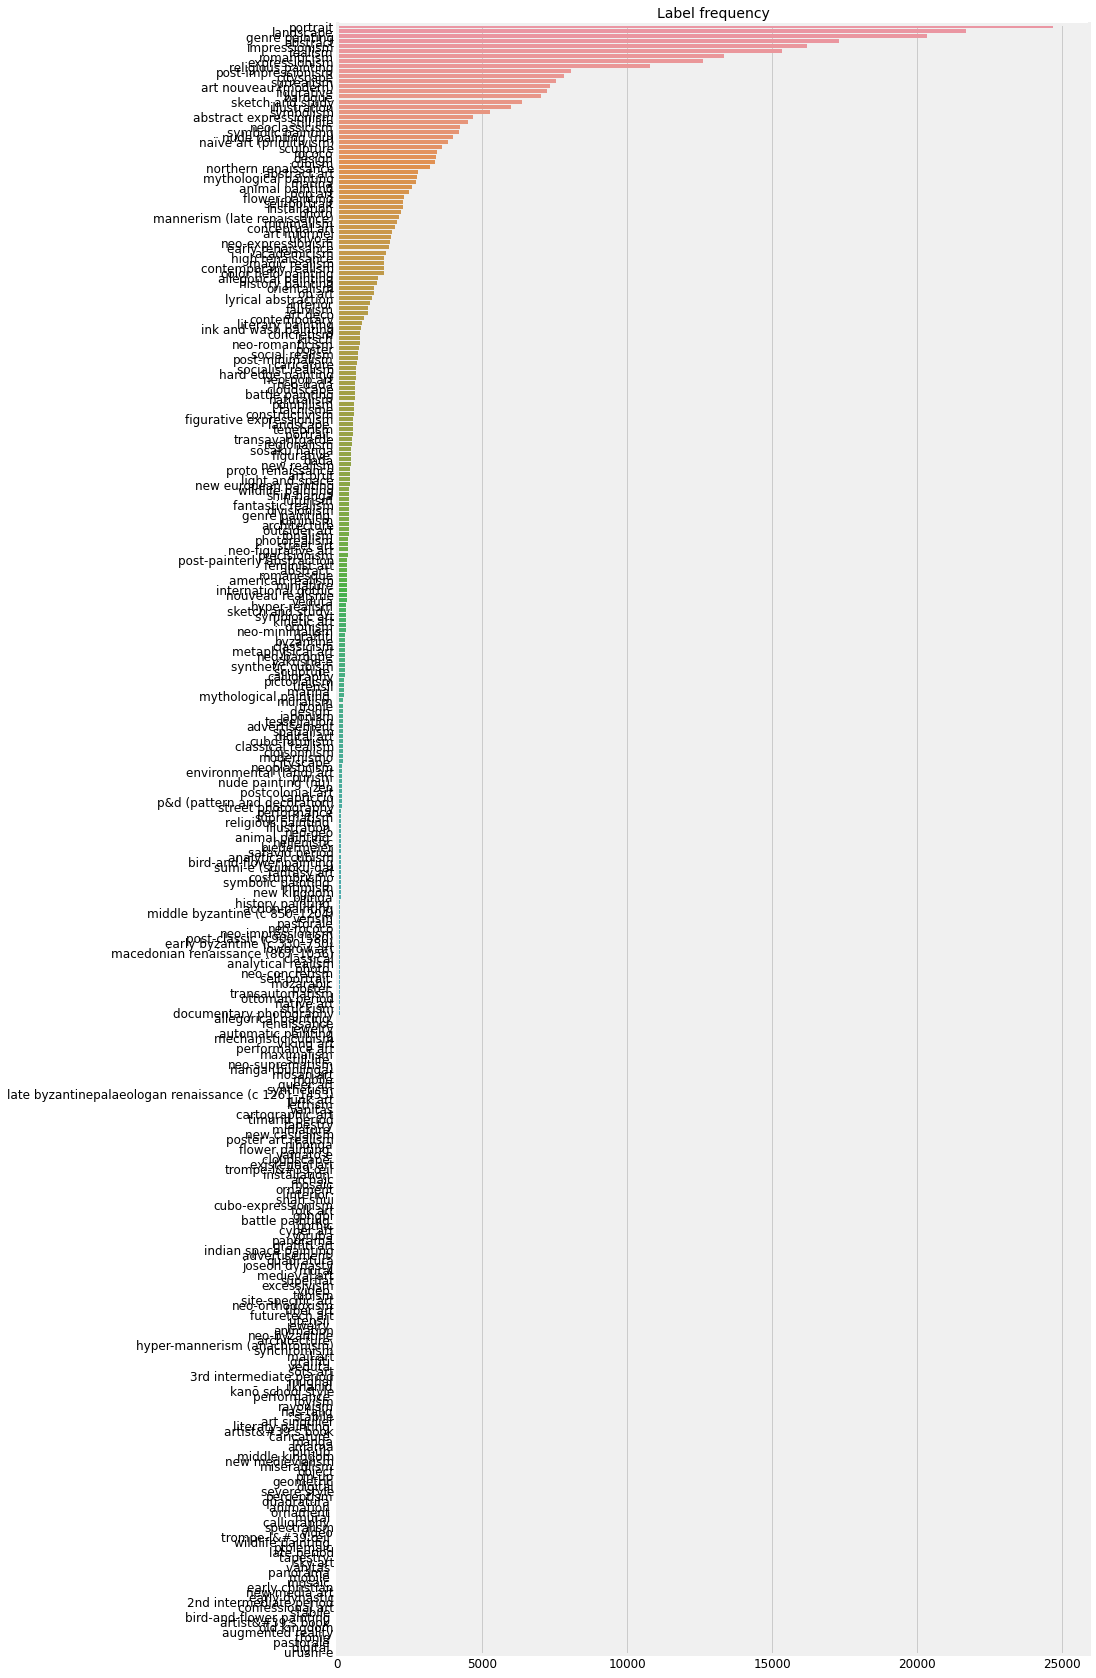

In [3]:
dir_path = './database_all'

file_list = os.listdir(dir_path)
ID = []
Labels = []

for file_name in file_list:
    label_list = file_name.split('+')
    if (label_list[0] == ''):
        continue
    ID.append(label_list[0])
    del label_list[0]
    # .jpg 제거
    label_list.pop()

    valid_label_list = []
    for label in label_list:
        label = label.lower()
        labels = label.split(', ')
        valid_label_list.extend(labels)

    while True:
        try:
            valid_label_list.remove('')
        except ValueError:
            break
    
    Labels.append(valid_label_list)

artworks = pd.DataFrame({"ID": ID, "Labels": Labels, "File": file_list})
artworks.dropna()

# Get label frequencies in descending order
label_freq = artworks['Labels'].apply(lambda s: [x for x in s]).explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12, 30))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [4]:
# Create a list of rare labels
rare = list(label_freq[label_freq < 50].index)
print("Number of used labels:", len(label_freq) - len(rare))
print("Number of ignored labels:", len(rare))

artworks['Labels'] = artworks['Labels'].apply(
    lambda s: [x for x in s if x not in rare])
artworks['Labels'] = artworks['Labels'].apply(lambda s: s if len(s) != 0 else np.nan)

artworks.dropna(inplace=True)

Number of used labels: 219
Number of ignored labels: 105


In [5]:
from sklearn.model_selection import train_test_split
# 파일 경로 및 label 집합으로 train data와 valid data parsing
X_train, X_val, y_train, y_val = train_test_split(artworks['File'], artworks['Labels'], test_size= 0.1, random_state = 23)

# MultiLabelBinarizer로 다중 label 이진화
mlb = MultiLabelBinarizer()
mlb.fit(artworks['Labels'])
y_train = mlb.transform(y_train)
mlb.fit(y_val)
y_val = mlb.transform(y_val)

print(y_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
IMG_SIZE = 224  # Specify height and width of image to match the input format of the model
CHANNELS = 3  # Keep RGB color channels to match the input format of the model

def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label


In [ ]:
def create_dataset(filenames, labels, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    dataset.batch(BATCH_SIZE)
    dataset.prefetch(buffer_size=AUTOTUNE)

dataset에 대한 전처리함수 parse_function과 여러 샘플에 대한 병렬 적용을 위한 num_parrallel_calls
dataset.cahce는 데이터 셋을 메모리 또는로컬 저장소에 캐시
dataset.prefetch는 전처리와 훈련스텝의 모델실행을 오버랩

In [ ]:
dataset_train = create_dataset(X_train, y_train)
dataset_val = create_dataset(X_val, y_val)

In [ ]:
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')

def conv_layer_1(x):
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)

    return x

def conv_layer_2(x):
    x = MaxPooling2D((3, 3), 2)(x)
    shortcut = x

    for i in range(3):
        if (i == 0):
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)
            shortcut = BatchNormalization()(shortcut)
        
        x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Add()([x, shortcut])
        x = Activation('relu')(x)

        shortcut = x
        
    return x

def conv_layer_3(x):
    for i in range (4):
        if (i == 0):
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            shortcut = BatchNormalization()(shortcut)
        
        x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)

        x = Add()([x, shortcut])(x)
        x = Activation('relu')(x)

        shortcut = x

    return x

def conv_layer_4(x):
    for i in range(6):
        if (i == 0):
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            shortcut = BatchNormalization()(shortcut)
        
        x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)

        x = Add()([x, shortcut])(x)
        x = Activation('relu')(x)

        shortcut = x
    
    return x

def conv_layer_5(x):
    for i in range(3):
        if (i == 0):
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            shortcut = BatchNormalization()(shortcut)

        x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')
        x = BatchNormalization()(x)
        
        x = Add()([x, shortcut])(x)
        x = Activation('relu')(x)

        shortcut = x
    
    return x

def ResNet50():
    x = conv_layer_1(input_tensor)
    x = conv_layer_2(x)
    x = conv_layer_3(x)
    x = conv_layer_4(x)
    x = conv_layer_5(x)

    x = GlobalAveragePooling2D()(x)
    output_tensor = Dense(K, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=output_tensor)



